In [16]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import plot_confusion_matrix

#### Data Import & Initial Munging
* Data was pulled from the bigquery pushshift.io dataset via SQL, with author, subreddit and count of number of posts from 2018
* Full SQL query:
    * SELECT author, subreddit, count(subreddit) FROM [fh-bigquery.reddit_posts.2018_12] WHERE author != "[deleted]" AND subreddit IS NOT NULL GROUP BY author, subreddit
* Included all months for 2018 within SQL query


In [6]:
#import data, 3 files with all 2018 posts split into between
raw_data_1 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_1.csv', sep = ",")
raw_data_2 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_2.csv', sep = ",")
raw_data_3 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_3.csv', sep = ",")

In [7]:
# merge dataframe
df_first = pd.merge(raw_data_1, raw_data_2, on=["author", "subreddit"], how= "outer" )
df= pd.merge(raw_data_3, df_first, on=["author", "subreddit"], how= "outer" )

In [8]:
#  checking to see how the merge has gone, need to deal with null values
df.head()

,author,subreddit,f0_,f0__x,f0__y
0,businessbrand121,business,8.0,NaN,NaN
1,GenericManChild,starbound,9.0,1.0,1.0
2,AutoModerator,AroundTheNFL,9.0,8.0,9.0
3,sleepinzombie,iphone,8.0,1.0,NaN
4,switchnbitch,GonewildAudible,8.0,NaN,7.0


In [9]:
#dealing with null values with 0 as they mean a user hasn't posted to that subreddit in one of the three periods
df.fillna(0, inplace= True)

In [10]:
df

,author,subreddit,f0_,f0__x,f0__y
0,businessbrand121,business,8.0,0.0,0.0
1,GenericManChild,starbound,9.0,1.0,1.0
2,AutoModerator,AroundTheNFL,9.0,8.0,9.0
3,sleepinzombie,iphone,8.0,1.0,0.0
4,switchnbitch,GonewildAudible,8.0,0.0,7.0
...,...,...,...,...,...
40347429,RadiationDM,thanosdidnothingwrong,0.0,0.0,7.0
40347430,MrMQuackens,thanosdidnothingwrong,0.0,0.0,7.0
40347431,shahkabra,thanosdidnothingwrong,0.0,0.0,7.0
40347432,himanxk,thanosdidnothingwrong,0.0,0.0,7.0


In [11]:
# create one variable with overall count of posts per subreddit per user
df["posts"] = df["f0_"] + df["f0__x"] + df["f0__y"]

In [12]:
#drop the remaining variables
df.drop(labels= ['f0_', 'f0__x', 'f0__y'], inplace= True, axis= 1)

In [13]:
#check for null values, 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40347434 entries, 0 to 40347433
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   author     object 
 1   subreddit  object 
 2   posts      float64
dtypes: float64(1), object(2)
memory usage: 1.2+ GB


In [14]:
# overwrite raw_data to save on memory usage
raw_data_1 = []
raw_data_2 = []
raw_data_3 = []

In [15]:
num_authors = len(df["author"].unique())
num_subreddits = len(df["subreddit"].unique())
num_posts = df["posts"].sum()

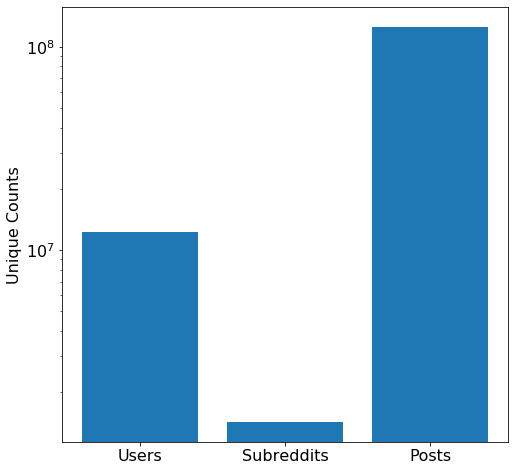

In [16]:
labels = [num_authors, num_subreddits, num_posts]
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize = (8, 8))
plt.bar(x = ["Users", "Subreddits", "Posts"], height= labels, log = True)
ax.set_ylabel("Unique Counts")
plt.show()


#### Convert Authors to Numerical Key
* As we don't want to delve into individual tastes, and to save on any issues with memory converting authors to a numerical key

In [17]:
# get list of unique authors
authors = df["author"].unique()
len(authors)

12196808

In [18]:
# creating dictionary in order to assign numerical value per author
authors_dict = {}
counter = 0
for i in authors:
    authors_dict[i] = counter
    counter +=1

In [19]:
# replace authors with created numerical key
df["author"] = [authors_dict[i] for i in df["author"]]

In [20]:
# delete dict to save memory
del authors_dict
del authors

#### Checking for outliers
* Visualisation of the data shows a number of outliers in terms of number of posts per user; high posters were often bots or spam and were removed


In [21]:
# every user has posted at least once to a specific subreddit, though seem to be a curiously high number of posts in some instances
pd.set_option('float_format', '{:f}'.format)
df.describe()

,author,posts
count,40347434.000000,40347434.000000
mean,4137176.743367,3.102450
std,3368923.448197,420.571889
min,0.000000,1.000000
25%,1122532.000000,1.000000
50%,3310141.000000,1.000000
75%,6514580.750000,2.000000
max,12196807.000000,2243748.000000


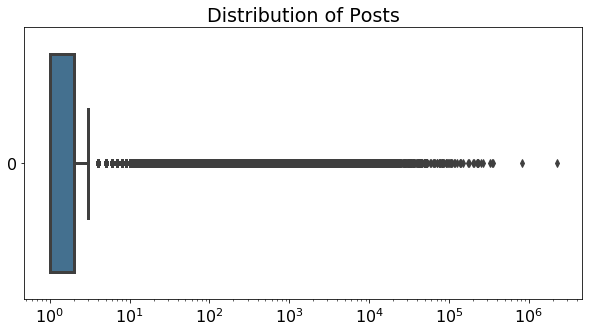

In [22]:
# check distribution of data, we see a high number of outliers which indicate strange behaviour

fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
sns.boxplot(data=df["posts"], orient='h', fliersize=5, linewidth=3,
            saturation=0.5, ax=ax)

ax.set_title('Distribution of Posts')
ax.set_xscale("log")
plt.show()

In [23]:
# we see there are a lot of bots included with these outliers which we will need to remove
df.sort_values(by = "posts", axis= 0, ascending= False)

,author,subreddit,posts
3993,3932,AutoNewspaper,2243748.000000
2848,2821,newsbotbot,819895.000000
4211710,2661946,TranscribersOfReddit,359610.000000
1702860,1321537,forexhome,345320.000000
2542328,1822605,removalbot,327779.000000
...,...,...,...
17058605,3681505,KotakuInAction,1.000000
17058604,5070668,BoJackHorseman,1.000000
17058603,3003823,BipolarSOs,1.000000
17058602,6964174,AskDocs,1.000000


In [24]:
# checking how many rows are more than 4 standard deviations from the mean number of posts
df_mean = df["posts"].mean()
df_std = df["posts"].std()
df_outliers = df[df["posts"] > df_mean + (df_std * 4)]

In [25]:
df_outliers

,author,subreddit,posts
488,485,BakaNewsJP,2008.000000
540,537,IceCells,2560.000000
677,674,de,3326.000000
890,883,SteamTradingCards,5218.000000
1341,959,nsfw,2073.000000
...,...,...,...
38347910,11873591,u_dof42704,1957.000000
38348341,11873676,battlemaps,2487.000000
38348692,11046393,russianworldcup2018,2484.000000
38349636,5519691,AskRedditUL,2222.000000


In [26]:
# as a large number of posters significantly higher than the mean appear to be bots or marketers, dropping them from the dataset
df = df[df["posts"] < df_mean + (df_std * 4)].copy()

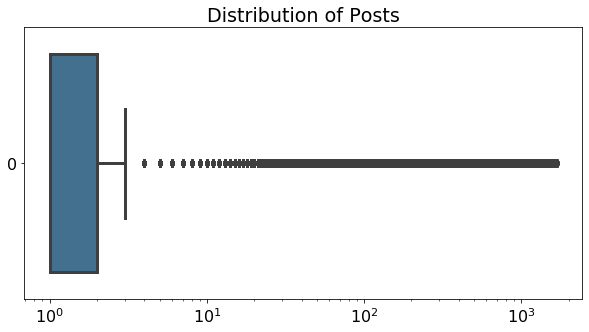

In [27]:
# after dropping outliers we see a more even distribution of data, though still a large number of outliers

fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
sns.boxplot(data=df["posts"], orient='h', fliersize=5, linewidth=3,
            saturation=0.5, ax=ax)

ax.set_title('Distribution of Posts')
ax.set_xscale("log")
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40345227 entries, 0 to 40347433
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   author     int64  
 1   subreddit  object 
 2   posts      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ GB


#### Understand Subreddit Usage per User
* Additionally, the majority of users only post to a small number of subreddits, any user who posts to less than 10 subreddits was dropped from the analyses


In [29]:
df[df["author"] == 4]

,author,subreddit,posts
4,4,GonewildAudible,15.000000
1693352,4,switchnbitch,35.000000
2777521,4,cassratesdickpics,1.000000
4205588,4,gonewildaudio,42.000000
4714720,4,GWABackstage,4.000000
6200926,4,PlayfulsIdeaBox,1.000000
9177783,4,winterspineapples,2.000000
12143326,4,DarkSidePlayground,4.000000
15869484,4,bubblegumfetish,1.000000
19397261,4,ShittyVeganFoodPorn,1.000000


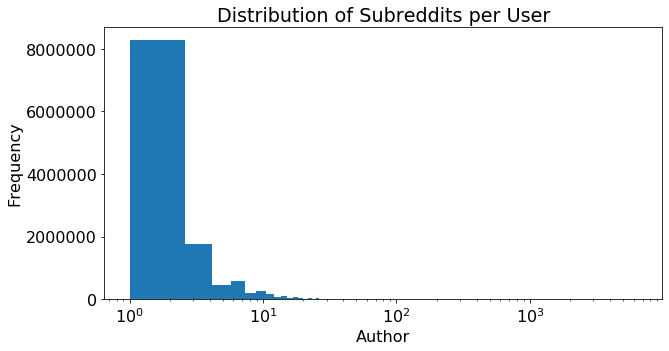

In [30]:
# log scale
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
df["author"].value_counts().plot(kind='hist', bins=4000, title='Distribution of Subreddits per User')
plt.xlabel('Author')
plt.ylabel('Frequency')
ax.set_xscale("log")
plt.show()

In [31]:
#get dict of unique counts 
author_count = df["author"].value_counts().to_dict()

# add column for frequency of users
df["freq"] = [author_count[i] for i in df["author"]]


In [32]:
# drop users who have posted to less than 10 subreddits, will not be useful for analysis
df = df[df["freq"] > 9].copy()

# drop frequncy column
df.drop(labels = "freq", axis= 1, inplace= True)

# del author_count to save memory
del author_count

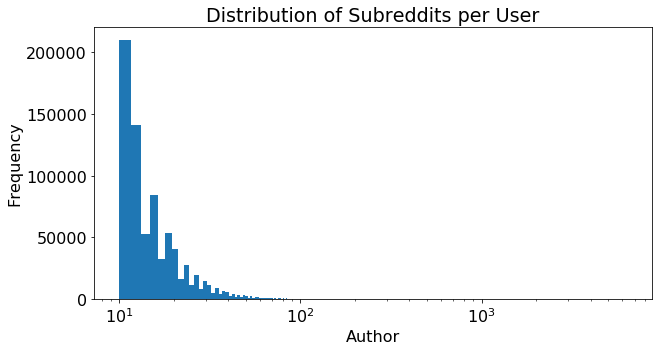

In [33]:
# log scale
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
df["author"].value_counts().plot(kind='hist', bins=4000, title='Distribution of Subreddits per User')
plt.xlabel('Author')
plt.ylabel('Frequency')
ax.set_xscale("log")
plt.show()

In [34]:
df

,author,subreddit,posts
1,1,starbound,11.000000
2,2,AroundTheNFL,26.000000
3,3,iphone,9.000000
4,4,GonewildAudible,15.000000
5,5,news,15.000000
...,...,...,...
40347429,258854,thanosdidnothingwrong,7.000000
40347430,3021827,thanosdidnothingwrong,7.000000
40347431,218376,thanosdidnothingwrong,7.000000
40347432,268449,thanosdidnothingwrong,7.000000



#### Combine mental health related subreddits for target variable
* Create target variable
* Turn into boolean, 1 for posting to mental health subreddits

In [35]:
#target reddits identified from r/anxiety related subreddits
string= """/r/mentalhealth/r/Anxiety/r/SuicideWatch/r/bipolar/r/bipolarreddit/r/depression/r/detachmentdisorder/r/dpdr/r/GFD/r/MentalHealth/r/mentalillness/r/stopselfharm/r/Agoraphobia/r/anxietydepression/r/HealthAnxiety/r/socialanxiety/r/Anxietyhelp"""
target_reddits = string.split("/r/")[1:]


In [36]:
df[df["subreddit"] == "depression"]

,author,subreddit,posts
470,469,depression,44.000000
1232,1224,depression,10.000000
4581,4495,depression,28.000000
5125,5021,depression,16.000000
6345,6204,depression,17.000000
...,...,...,...
40262160,191693,depression,4.000000
40274874,2745368,depression,6.000000
40275600,3518907,depression,6.000000
40276406,2486550,depression,6.000000


In [37]:
#get list of unique subreddits
subreddits = df["subreddit"].unique()
len(subreddits)

369632

In [38]:
# group together target variable
df["subreddit"] = ["df_target" if i in target_reddits else i for i in df["subreddit"]]

df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,44.000000
1232,1224,df_target,10.000000
4581,4495,df_target,28.000000
5125,5021,df_target,16.000000
6300,6159,df_target,28.000000
...,...,...,...
40274874,2745368,df_target,6.000000
40275600,3518907,df_target,6.000000
40276406,2486550,df_target,6.000000
40277455,6772860,df_target,6.000000


In [39]:
#turn to boolean for prediction
df.loc[df["subreddit"] == "df_target", ["posts"]] = 1 
df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,1.000000
1232,1224,df_target,1.000000
4581,4495,df_target,1.000000
5125,5021,df_target,1.000000
6300,6159,df_target,1.000000
...,...,...,...
40274874,2745368,df_target,1.000000
40275600,3518907,df_target,1.000000
40276406,2486550,df_target,1.000000
40277455,6772860,df_target,1.000000


In [40]:
#check for duplicates, boolean now so can remove
df[df["subreddit"] == "df_target"].duplicated()

470         False
1232        False
4581        False
5125        False
6300        False
            ...  
40274874    False
40275600    False
40276406     True
40277455     True
40278719     True
Length: 50928, dtype: bool

In [41]:
df.drop_duplicates(inplace= True)

In [42]:
df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,1.000000
1232,1224,df_target,1.000000
4581,4495,df_target,1.000000
5125,5021,df_target,1.000000
6300,6159,df_target,1.000000
...,...,...,...
40261395,862669,df_target,1.000000
40262160,191693,df_target,1.000000
40271243,2268526,df_target,1.000000
40274874,2745368,df_target,1.000000


#### Merge Tiny Subreddits
* High number of subreddits have less than 10 posters, often related to personal usernames, merging these into one feature 


In [43]:
# we see over 1 million subreddits which only have one user, merging these into "single_user_reddits"
single_df = df.groupby("subreddit").count()[df.groupby("subreddit").count()["author"] < 11]
single_df

,author,posts
subreddit,,
*polhold00214,1,1
000000000000O0000000,1,1
001,1,1
0010000010000011001,1,1
0011110000110011,2,2
...,...,...
zzz,1,1
zzzCOLDPIZZAzzz,1,1
zzzz,2,2


In [44]:
single_user_subreddits = single_df.index

In [45]:
# renaming single user subreddits to one variable
df["subreddit"] = ["single_user_subreddits" if i in single_user_subreddits else i for i in df["subreddit"]]

# delete for memory
del single_user_subreddits
del single_df

In [273]:
#final file to take through for processing
df.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataFinal.csv'")